In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates
from cycler import cycler
from collections import OrderedDict
import matplotlib.mlab as ml
from scipy import optimize

%matplotlib notebook

In [2]:
# Save plots?
save = False

# Load and plot real time raw data from analysis.h5

In [3]:
# Load HDF file
folder = 'T2_refractive_index_liquids3'
data_folder = '../Data/'  # 'Z:/LabOnChip/Data/'
df = pd.HDFStore(data_folder + str(folder) +'/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

df.head()
# df.info()

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
0,2016-10-11 11:02:12.034481,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,1,400,21.5,21.5,22.47,0.536418,12.447777,-0.018691,0.000000
1,2016-10-11 11:02:12.440521,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,2,400,21.5,21.5,22.47,0.539822,12.447418,-0.018640,0.006767
2,2016-10-11 11:02:12.772554,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,3,400,21.5,21.5,22.47,0.538683,12.448396,-0.018848,0.012301
3,2016-10-11 11:02:12.986576,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,4,400,21.5,21.5,22.47,0.539075,12.444511,-0.018714,0.015868
4,2016-10-11 11:02:13.168594,T2,0.5,0.0001,44.29,T2_refractive_index_liquids3,Air,1.0,0.222335,1200,5,400,21.5,21.5,22.47,0.538458,12.448942,-0.018894,0.018902


<IPython.core.display.Javascript object>


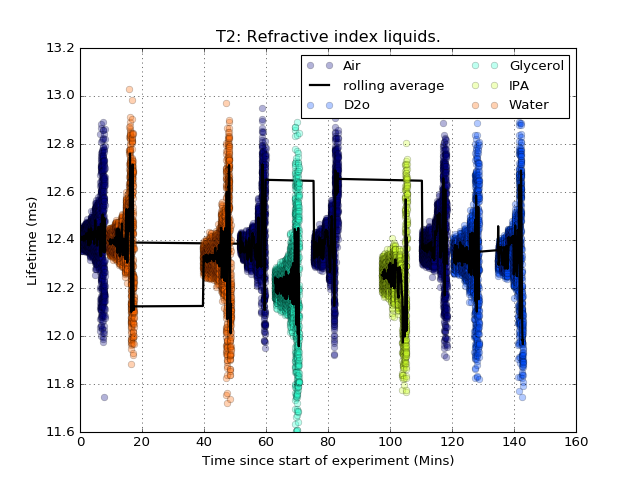

In [4]:
# Create colormap for plotting
n = len(df.medium.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# All in one
fig, ax = plt.subplots()

for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
#     ax.plot(group['delta'], rolling, '-', lw=2, label='rolling ({k})'.format(k=key), color='black')
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
plt.title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime_raw.png', dpi=300)

# Drop Data

Drop first water measurement - check on plot above that correct data is dropped

In [5]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 1) & (df['current'] == 0.5)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
2000,2016-10-11 11:11:36.044876,T2,0.5,0.0001,45.13,T2_refractive_index_liquids3,Water,1.33,0.221851,1200,1,400,21.75,21.5,22.39,0.434297,12.344714,-0.018238,9.400173
4000,2016-10-11 11:41:51.472048,T2,0.5,0.0001,44.42,T2_refractive_index_liquids3,Water,1.33,0.223544,1200,1,400,22.25,22.0,22.78,0.406367,12.284894,-0.017880,39.657293


In [6]:
df[(df['medium'] == 'Water') & (df['sweep_no'] == 400) & (df['current'] == 0.1)]

,datetime,chip,current,fs,humidity,measurementID,medium,n,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
3999,2016-10-11 11:19:32.610528,T2,0.1,0.0001,44.94,T2_refractive_index_liquids3,Water,1.33,0.028925,1200,400,400,21.75,21.5,22.40,0.048458,12.366795,-0.017873,17.342934
5999,2016-10-11 11:50:55.162728,T2,0.1,0.0001,44.26,T2_refractive_index_liquids3,Water,1.33,0.028603,1200,400,400,22.25,22.0,22.78,0.045851,12.353501,-0.018609,48.718804


In [7]:
df = df.iloc[np.where((df.index < 2000) | (df.index > 3999))[0]]

Drop unwanted medium

In [8]:
# Drop data (error measurements) - IPA was evaporating 
to_drop = ['D2o']
df = df[~df['medium'].isin(to_drop)]

Replot data in time to check correct data was dropped

<IPython.core.display.Javascript object>


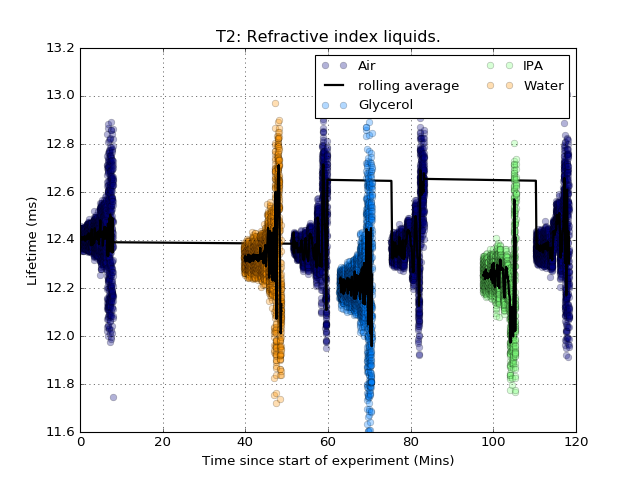

In [9]:
# Create colormap for plotting
n = len(df.medium.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# All in one
fig, ax = plt.subplots()

for key, group in df.groupby(['medium']):
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
#     ax.plot(group['delta'], rolling, '-', lw=2, label='rolling ({k})'.format(k=key), color='black')
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
plt.title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime.png', dpi=300)

## Group by current and refractive index and evaluate averate tau & A

In [18]:
# Drop unwanted columns (data not interested in, easier to view)
df = df[['n', 'current', 'tau', 'A', 'medium']]
# Apply mean and std functions to all collumns
g = df.groupby(['current', 'n']).agg([np.mean, np.std]).reset_index()
g.head()

current     n        tau                   A          
                      mean       std      mean       std
0     0.1  1.00  12.458826  0.233409  0.055755  0.003482
1     0.1  1.33  12.356575  0.293052  0.045875  0.000919
2     0.1  1.37  12.169651  0.240522  0.049110  0.000761
3     0.1  1.47  12.238032  0.321725  0.043909  0.001020
4     0.2  1.00  12.404007  0.089143  0.167799  0.008788

<IPython.core.display.Javascript object>


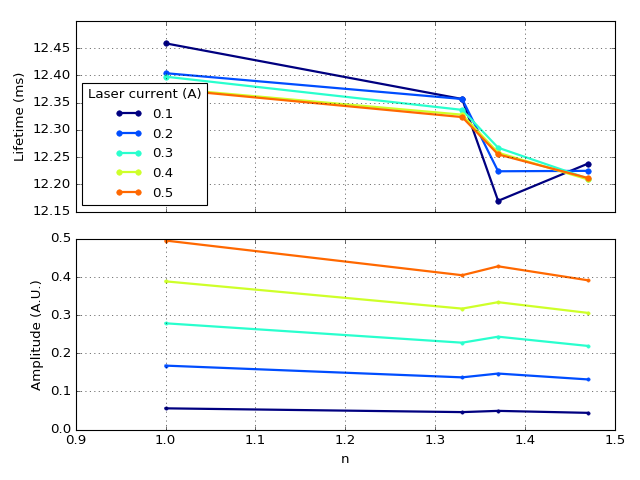

In [19]:
# Create colormap for plotting
num = len(df.current.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/num) for i in range(num)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for key, group in g.groupby('current'):
    ax1.plot(group['n'], group['tau']['mean'], '.-', lw='2', markersize='10', label=key)
    ax2.plot(group['n'], group['A']['mean'], '.-', lw='2', label=key)

ax2.set_xlabel('n')
ax1.set_ylabel('Lifetime (ms)')
ax2.set_ylabel('Amplitude (A.U.)')

ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')
# ax1.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
ax1.legend(title='Laser current (A)', loc='best', fontsize='medium')
if save:
    plt.savefig(data_folder +  str(folder) + '/final.png', dpi=500)

<IPython.core.display.Javascript object>


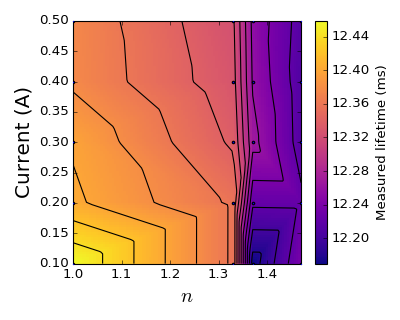

In [20]:
# Contour plot
x = g.n
y = g.current
z = g['tau']['mean']
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(111)
plt.contour(xi, yi, zi, 15, linewidths=1, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
cbar = plt.colorbar()
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)

plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar.ax.set_ylabel('Measured lifetime (ms)', fontsize=12)
ax.set_xlabel('$n$', fontsize=18)
ax.set_ylabel('Current (A)', fontsize=18)
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/contour_tau.png', dpi=300)

# Decay Rates

In [21]:
df['decayRate'] = 1E3/df['tau']

In [22]:
# Average data over all currents
g = df.groupby('n').agg([np.mean, np.std]).reset_index()
g.head()

n current                  tau                   A            decayRate  \
           mean       std       mean       std      mean       std       mean   
0  1.00     0.3  0.141430  12.402377  0.120482  0.277394  0.156626  80.637278   
1  1.33     0.3  0.141457  12.340222  0.144172  0.226599  0.127077  81.046861   
2  1.37     0.3  0.141457  12.234742  0.122142  0.240436  0.133762  81.742603   
3  1.47     0.3  0.141457  12.218752  0.156918  0.218498  0.123042  81.854889   

             
        std  
0  0.779939  
1  0.945944  
2  0.816599  
3  1.049695

<IPython.core.display.Javascript object>


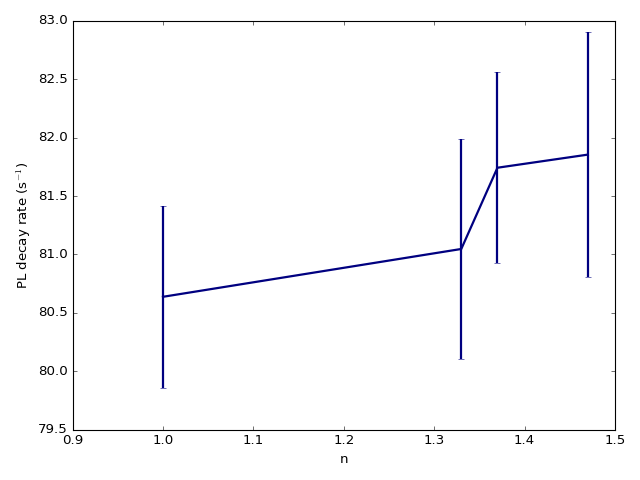

In [23]:
# Two subplots, unpack the axes array immediately
f, ax = plt.subplots()
ax.errorbar(g['n'], g['decayRate']['mean'], yerr=g['decayRate']['std'], lw='2')
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
# plt.ylim(80, 82)
# ax1.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
if save:
    plt.savefig(data_folder +  str(folder) + '/decayRate.png', dpi=300)

<IPython.core.display.Javascript object>


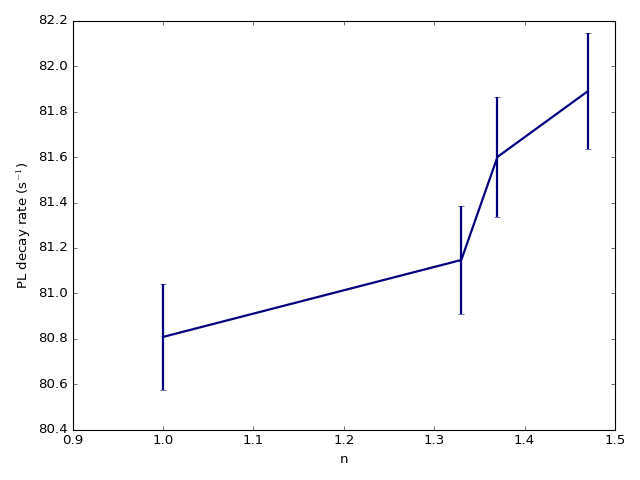

In [24]:
# Single current - 0.5 has strongest signal and was first measurement
g = df.groupby(['current', 'n']).agg([np.mean, np.std]).reset_index()
g = g[g['current'] == 0.5].reset_index()

# Two subplots, unpack the axes array immediately
f, ax = plt.subplots()
ax.errorbar(g['n'], g['decayRate']['mean'], yerr=g['decayRate']['std'], lw='2')
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
# ax1.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
if save:
    plt.savefig(data_folder +  str(folder) + '/decayRate.png', dpi=300)

<IPython.core.display.Javascript object>


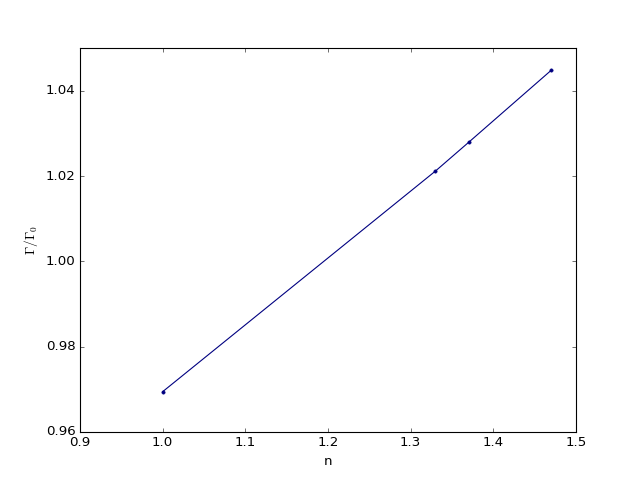

In [29]:
# Load theoretical decay rates vs n and plot
data = np.load(data_folder + 'T2_simulated_decay_Rate/spe_vs_n_t2_nosubstrate.npz')
n = data['n']
spe = data['spe']
f, ax = plt.subplots()
ax.plot(n, spe, '.-')
ax.errorbar(g['n'], g['decayRate']['mean'], yerr=g['decayRate']['std'], lw='2')
ax.set_xlabel('n')
ax.set_ylabel('$\Gamma / \Gamma_0$')

In [34]:
xdata = g['n']
ydata = g['decayRate']['mean']
yerr=g['decayRate']['std']

[ 78.649846     2.09124932]
Quantum efficiency is 2.59 %


<IPython.core.display.Javascript object>


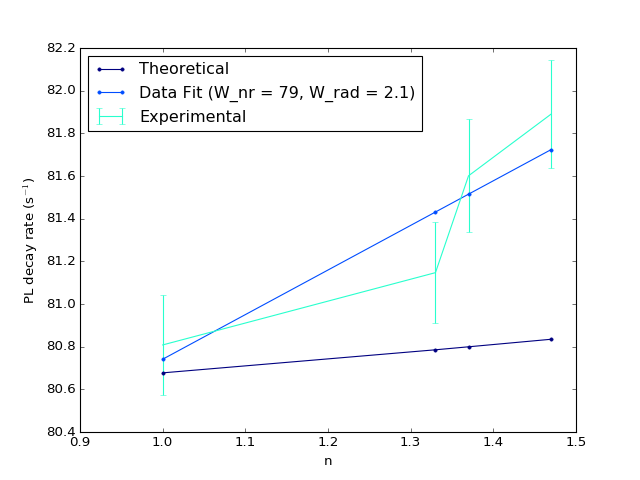

In [144]:
# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [40, 40]
out = optimize.leastsq(errfunc, pinit,
                       args=(xdata, ydata, yerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)

QE = lambda W_rad, W_nr: W_rad / (W_rad + W_nr)
print('Quantum efficiency is {:.2f} %'.format(100*QE(W_rad, W_nr)))

W_total = lambda p, x: p[0] + p[1] * x
W_nr = pfinal[0]
W_rad = pfinal[1]

f, ax = plt.subplots()
ax.plot(n, W_total(pfinal, spe), '.-', label='Theoretical')
ax.plot(n, fitfunc(pfinal, xdata), '.-', label='Data Fit (W_nr = {0:.2g}, W_rad = {1:.2g})'.format(W_nr, W_rad))
ax.errorbar(xdata, ydata, yerr=yerr, label='Experimental')
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


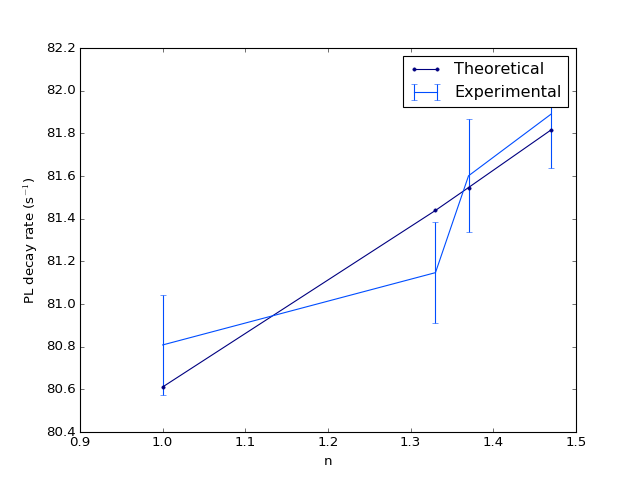

In [136]:
W_total = lambda p, x: p[0] + p[1] * x

W_nr = 65.1
W_rad = 16
p = [W_nr, W_rad]

f, ax = plt.subplots()
ax.plot(n, W_total(p, spe), '.-', label='Theoretical')
ax.errorbar(xdata, ydata, yerr=yerr, label='Experimental')
ax.set_xlabel('n')
ax.set_ylabel('PL decay rate (s$^{-1}$)')
plt.legend()

In [112]:
W_nr

48

In [113]:
W_rad

33